

**Project Introduction**

Github: https://github.com/donxiya/poetry-generator/blob/main/poetry-generater.ipynb

Recent advances in natural language processing have enabled deeper exploration of emotional expression in poetry. For instance, the PO-EMO dataset introduced by Haider et al. (2020) focuses on aesthetic emotions in English and German poetry, using transformer-based models to identify nuanced emotional responses such as nostalgia or serenity rather than basic sentiment classes. Similarly, other studies have demonstrated the effectiveness of fine-tuning BERT-like models on emotion-tagged English poems, achieving strong classification performance across categories like joy, anger, and sadness (Kumar & Srinivasan, 2022). These findings highlight the feasibility of applying deep learning methods—especially transformer architectures—to complex emotional inference tasks in poetic language.

This project focuses on the classification and generation of English poems based on their textual content and emotional context. Using the Poetry Foundation Emotion-Annotated Dataset from Kaggle (source), which consists of poems scraped from the Poetry Foundation website, the dataset contains four key attributes: Title, Poem, Poet, and Genre. The Genre column represents an emotion-based classification derived by applying a fine-tuned BERT model that annotates the poems with emotion labels.

The primary goal of this project is to build a robust classifier capable of accurately categorizing poems into their corresponding emotional genres based on the text content. Beyond classification, the ultimate aim is to develop a generative model that can create new poems conditioned on specific words or emotional genres, thereby blending natural language understanding with creative text generation.

This work combines classical machine learning techniques, deep learning architectures such as BERT, and natural language processing methods to analyze and generate poetry, contributing to the intersection of computational creativity and emotion-aware language modeling.



**Project Goals Summary**

The objectives of this project are as follows:

**Poem Emotion Classification:**

Develop a reliable model to classify English poems into distinct emotional genres using the text content. This involves leveraging pretrained language models such as BERT for feature extraction and fine-tuning on the annotated dataset.

**Poetry Generation:**

Build a generative model capable of creating new poems conditioned on specified emotional genres or input keywords, enhancing computational creativity.



**Citation:**

Haider, T., Boleda, G., & Zampieri, M. (2020). PO-EMO: Conceptualizing and Annotating Aesthetic Emotions in Poetry. arXiv preprint arXiv:2009.10885. https://arxiv.org/abs/2009.10885

Kumar, R., & Srinivasan, P. (2022). Emotion Detection in Poetry using Transformer-based Models. Proceedings of the ACL Workshop on Computational Approaches to Literature.

Ekhaldi, A. (2022). English Poem Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/abdelrahmanekhaldi/english-poem-dataset



In [28]:


import warnings
warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, RepeatVector, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

# Huggingface Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel, TFDistilBertModel, DataCollatorWithPadding, DistilBertTokenizer

# Jupyter / IPython widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

In [29]:

# Loading the file
csv_file_path = '/kaggle/input/english-poem-dataset/PoemDataset.csv'
df = pd.read_csv(csv_file_path)

df.shape
df.info()
print(df['Poem'].iloc[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   9999 non-null   object
 1   Poem    9928 non-null   object
 2   Poet    10000 non-null  object
 3   Genre   10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB
Wandered tonight through a cityas ruined as a body with brokenribs and a bared heart. Looked for you there with cookies in my pocket, searched for a sigh, for movement in demolished streets and alleys. Tonightsince I’d forgotten for a moment where you are,I searched for you with hope in my bones.But no matter how I lured you with my voiceand my eyes, walls of debris grew up steadily around you, cellars seemedto creep around you. I remained alonewith those cookies in my pocketand kept calling and walking.


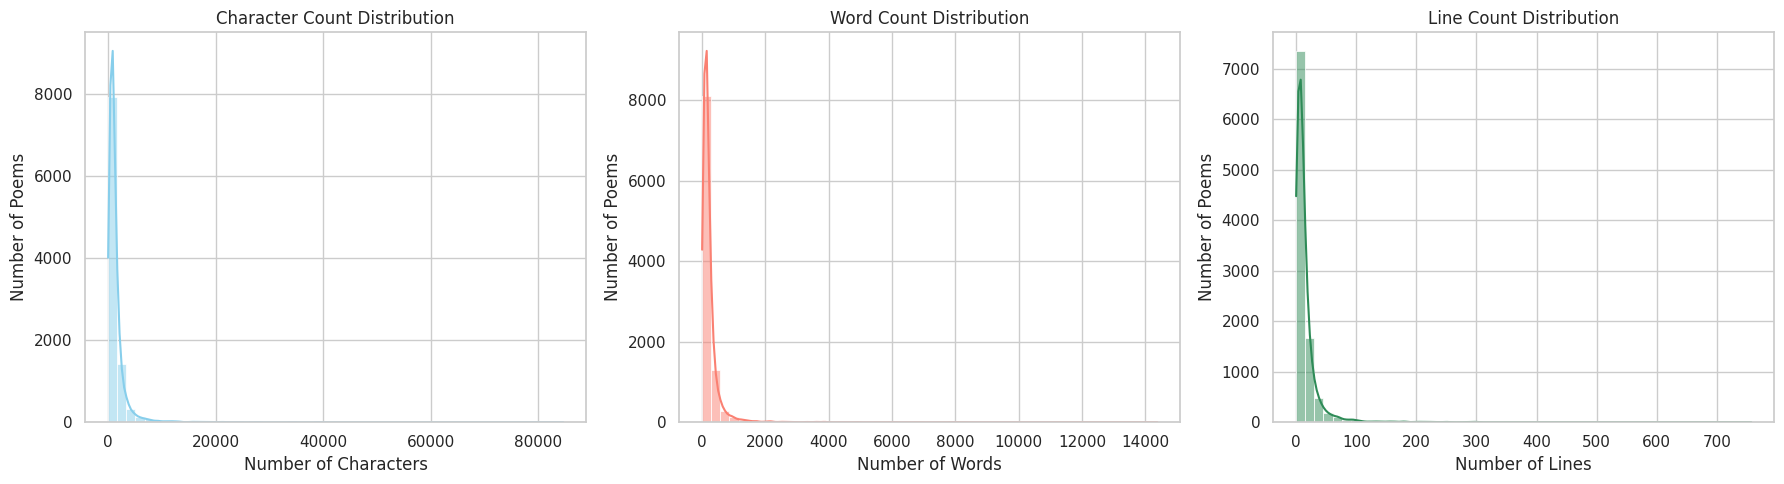

In [30]:

#EDA: Analyze character count and sentence count of each poem

# Add character count
df['char_count'] = df['Poem'].astype(str).apply(len)
# Add word count
df['word_count'] = df['Poem'].astype(str).apply(lambda x: len(x.split()))
# Add line count
df['line_count'] = df['Poem'].astype(str).apply(lambda x: len(re.split(r'[.;!?]', x)) - 1)

df[['char_count', 'word_count', 'line_count']].describe()

sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Character count histogram
sns.histplot(df['char_count'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Character Count Distribution')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Number of Poems')

# Word count histogram
sns.histplot(df['word_count'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Number of Poems')

# Line count histogram
sns.histplot(df['line_count'], bins=50, kde=True, ax=axes[2], color='seagreen')
axes[2].set_title('Line Count Distribution')
axes[2].set_xlabel('Number of Lines')
axes[2].set_ylabel('Number of Poems')

plt.tight_layout()
plt.show()


The dataset presents significant variability in poem length. Some entries consist of just a single line or a short phrase, while others span several hundred words

95% of poems have 634 words or fewer.
Original word count stats:
count    10000.000000
mean       231.123200
std        433.184481
min          1.000000
25%         90.000000
50%        139.000000
75%        241.000000
max      14371.000000
Name: word_count, dtype: float64
Dataset size after basic cleaning: (9921, 7)
Removed 578 poems longer than 634 words.
Cleaned dataset size after length filtering: (9422, 7)


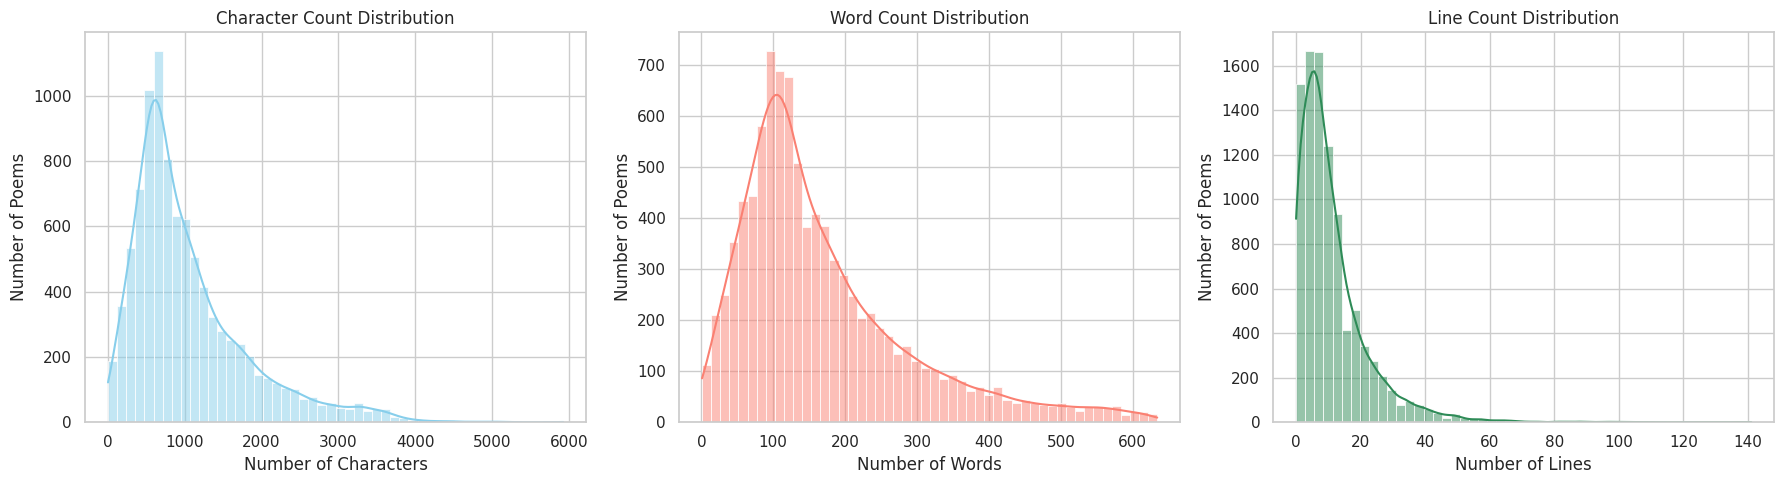

In [31]:

#EDA data cleaning
#Calculate the 95th percentile threshold for word counts
threshold_95 = df['word_count'].quantile(0.95)
print(f"95% of poems have {threshold_95:.0f} words or fewer.")

print("Original word count stats:")
print(df['word_count'].describe())

# Start cleaning from original df (drop NaNs, blanks)
df_clean = df.dropna(subset=['Poem', 'Genre']).copy()
df_clean = df_clean[df_clean['Poem'].str.strip() != '']
df_clean = df_clean[df_clean['Genre'].str.strip() != '']

# Drop duplicates in Poem column (optional but recommended)
df_clean = df_clean.drop_duplicates(subset=['Poem']).reset_index(drop=True)

print(f"Dataset size after basic cleaning: {df_clean.shape}")

# Now filter by word count threshold (keep only poems <= threshold)
df_clean = df_clean[df_clean['word_count'] <= threshold_95].reset_index(drop=True)

print(f"Removed {len(df) - len(df_clean)} poems longer than {threshold_95:.0f} words.")
print(f"Cleaned dataset size after length filtering: {df_clean.shape}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Character count histogram
sns.histplot(df_clean['char_count'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Character Count Distribution')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Number of Poems')

# Word count histogram
sns.histplot(df_clean['word_count'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Number of Poems')

# Line count histogram
sns.histplot(df_clean['line_count'], bins=50, kde=True, ax=axes[2], color='seagreen')
axes[2].set_title('Line Count Distribution')
axes[2].set_xlabel('Number of Lines')
axes[2].set_ylabel('Number of Poems')

plt.tight_layout()
plt.show()


**EDA: Data CLeaning**

**Basic Filtering**:

Removed rows with missing (NaN) or empty values in the Poem and Genre columns.

Eliminated duplicate entries based on the Poem text to ensure unique samples.

**Length-Based Outlier Removal**:

Calculated the 95th percentile of poem word counts.

Filtered out poems exceeding this threshold to exclude extremely long outliers that could skew model input distributions or exceed transformer input limits.

**Post-Cleaning Stats and Visualizatio**n:

Displayed the distribution of character count, word count, and line count using histograms, helping to verify the effect of length filtering and better understand the structure of the cleaned dataset.

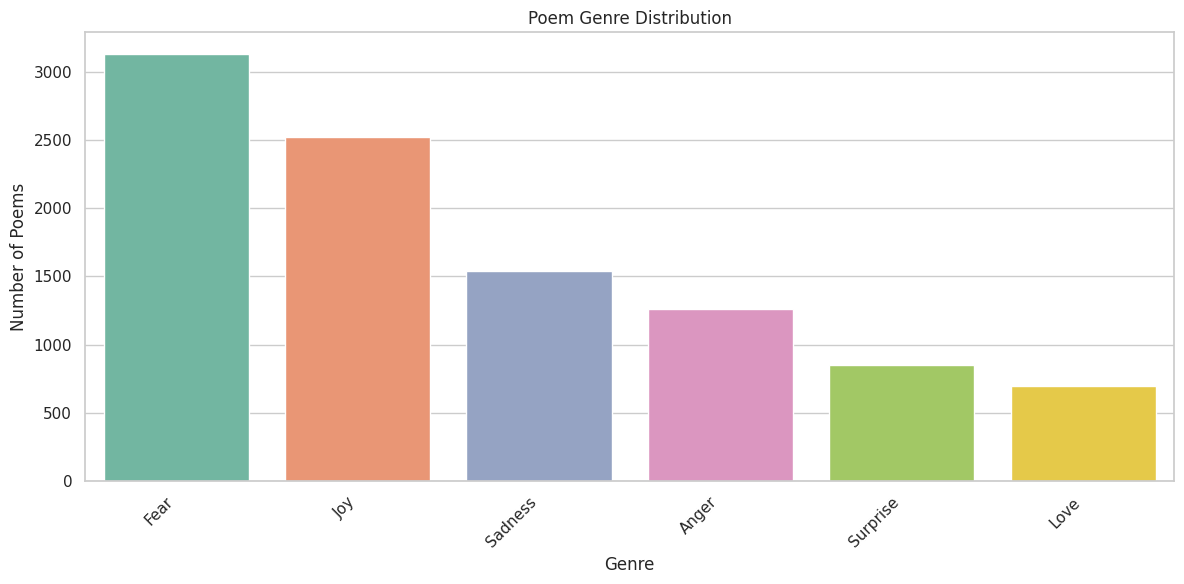

In [32]:

#Genre distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index, palette='Set2')
plt.title('Poem Genre Distribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Number of Poems')
plt.tight_layout()
plt.show()


**Category distribution**:

the distribution varies, but the total number is too small to be removed.

In [33]:

# EDA: Data Processing
# Encode labels

le = LabelEncoder()
df_clean['genre_encoded'] = le.fit_transform(df_clean['Genre'])

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['Poem'], df_clean['genre_encoded'], test_size=0.2, random_state=42, stratify=df_clean['genre_encoded']
)

# Vectorize with TF-IDF, removing English stopwords
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



Accuracy: 0.3926
Classification Report:
              precision    recall  f1-score   support

       Anger       0.42      0.10      0.16       227
        Fear       0.41      0.71      0.52       596
         Joy       0.39      0.52      0.45       473
        Love       0.44      0.05      0.09       135
     Sadness       0.27      0.12      0.17       292
    Surprise       0.33      0.04      0.07       162

    accuracy                           0.39      1885
   macro avg       0.38      0.26      0.24      1885
weighted avg       0.38      0.39      0.33      1885



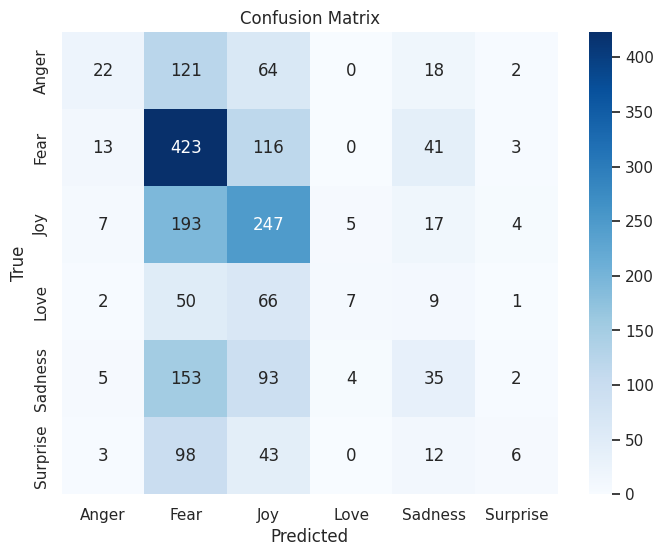

In [34]:

# EDA: Supervised ML: LogisticRegression

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate as needed
y_pred = clf.predict(X_test_tfidf)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




**Logistic Regression Summary**

A logistic regression model was used as a baseline for emotion classification in poems. With an accuracy of 39.3% and poor performance on several emotion classes, the results indicate that this model is not sufficient for capturing the complex and subtle emotional cues in poetic language. More advanced models are needed to improve classification.


**Deep Learning Approaches for Emotion Classification in Poetry**

To improve upon traditional methods, I will explore deep learning models including LSTM, GRU, and BERT for emotion classification in poems.

**LSTM and GRU** are types of recurrent neural networks that can capture long-range dependencies and contextual information in sequences, which is essential for understanding the flow and nuance in poetic language.

**BERT**, a powerful transformer-based model, provides contextualized word embeddings and has shown state-of-the-art results in many NLP tasks, including emotion and sentiment analysis.

These deep learning methods are necessary because poetry often contains subtle, complex emotional expressions that simple models like logistic regression struggle to capture. By leveraging sequence modeling and contextual understanding, these approaches aim to better grasp the emotional tone conveyed in poems.











In [36]:

BATCH_SIZE = 32
EPOCH = 10
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 100
GENRE_VOCAB_SIZE = 6
EMBEDDING_DIM = 64


**LSTM for Poetry Emotion Classification**

LSTMs capture word order and context in sequences, making them useful for modeling emotional flow in poems. However, they may struggle with complex language and long-range dependencies, limiting their effectiveness on subtle poetic emotions.

In [37]:


# Prepare labels
le = LabelEncoder()
labels = le.fit_transform(df_clean['Genre'])
num_classes = len(le.classes_)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['Poem'], labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenize text - Initialize tokenizer first
max_vocab_size = 1000
max_seq_len = 200  

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Fit only on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post', truncating='post')

# Convert labels to categorical (one-hot)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


**Embedding Layer:**

Converts input word indices into dense vectors of embedding_dim size.

**Bidirectional LSTM Layer:**

Processes the sequence in both forward and backward directions with units number of hidden units, capturing context from both ends.

**Dense Layer (ReLU):**

Applies a fully connected layer with ReLU activation and L2 regularization to learn non-linear combinations of LSTM outputs.

**Dropout Layer:**

Randomly drops units during training to prevent overfitting (dropout rate).

**Output Dense Layer (Softmax):**

Predicts class probabilities across num_classes output categories.

In [10]:

# Build model
def build_model(embedding_dim=EMBEDDING_DIM, units=64, dropout=0.5,
                max_vocab_size=max_vocab_size, max_seq_len=10, num_classes=GENRE_VOCAB_SIZE):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_vocab_size, embedding_dim, input_length=max_seq_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False)),
        tf.keras.layers.Dense(
            units, 
            activation='relu', 
            kernel_regularizer=regularizers.l2(0.001)
        ),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model




In [11]:


early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=2,
    restore_best_weights=True,
    verbose=1                
)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stop, checkpoint]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

In [12]:


lstm_model = build_model(embedding_dim=128, units=64, dropout=0.2, max_vocab_size=1000, max_seq_len=10, num_classes=6)
lstm_model.build(input_shape=(None, max_seq_len))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()
# Train
lstm_history = lstm_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose = 2
)


2025-06-21 17:48:49.012191: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,462 (919.77 KB)

 Trainable params: 235,462 (919.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
212/212 - 34s - 162ms/step - accuracy: 0.1610 - loss: 1.8287 - val_accuracy: 0.1512 - val_loss: 1.8226
Epoch 2/10
212/212 - 27s - 127ms/step - accuracy: 0.1470 - loss: 1.8022 - val_accuracy: 0.0782 - val_loss: 1.8151
Epoch 3/10
212/212 - 27s - 125ms/step - accuracy: 0.1675 - loss: 1.7958 - val_accuracy: 0.1406 - val_loss: 1.8003
Epoch 4/10
212/212 - 28s - 130ms/step - accuracy: 0.1381 - loss: 1.7824 - val_accuracy: 0.1512 - val_loss: 1.7872
Epoch 5/10
212/212 - 27s - 127ms/step - accuracy: 0.1707 - loss: 1.7495 - val_accuracy: 0.1379 - val_loss: 1.7856
Epoch 6/10
212/212 - 27s - 126ms/step - accuracy: 0.1840 - loss: 1.6977 - val_accuracy: 0.1233 - val_loss: 1.8318
Epoch 7/10
212/212 - 27s - 127ms/step - accuracy: 0.2194 - loss: 1.6178 - val_accuracy: 0.1512 - val_loss: 1.8496
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 5.


Epoch  1 | Train Acc: 0.1610 | Val Acc: 0.1512 | Train Loss: 1.8287 | Val Loss: 1.8226
Epoch  2 | Train Acc: 0.1470 | Val Acc: 0.0782 | Train Loss: 1.8022 | Val Loss: 1.8151
Epoch  3 | Train Acc: 0.1675 | Val Acc: 0.1406 | Train Loss: 1.7958 | Val Loss: 1.8003
Epoch  4 | Train Acc: 0.1381 | Val Acc: 0.1512 | Train Loss: 1.7824 | Val Loss: 1.7872
Epoch  5 | Train Acc: 0.1707 | Val Acc: 0.1379 | Train Loss: 1.7495 | Val Loss: 1.7856
Epoch  6 | Train Acc: 0.1840 | Val Acc: 0.1233 | Train Loss: 1.6977 | Val Loss: 1.8318
Epoch  7 | Train Acc: 0.2194 | Val Acc: 0.1512 | Train Loss: 1.6178 | Val Loss: 1.8496


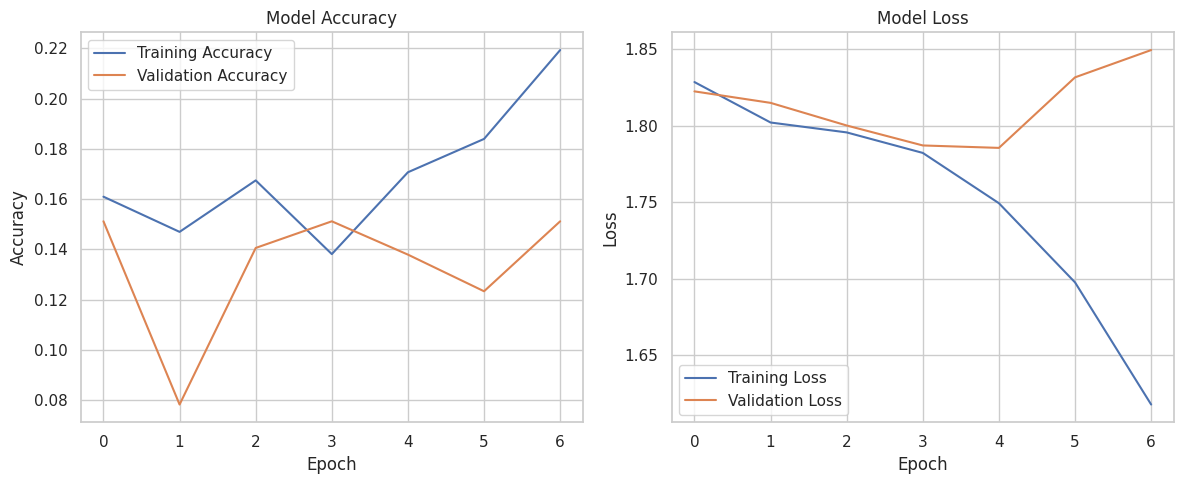

In [13]:


# Retrieve values from the history object
history_dict = lstm_history.history

for epoch in range(len(history_dict['loss'])):
    print(f"Epoch {epoch+1:2d} | "
          f"Train Acc: {history_dict['accuracy'][epoch]:.4f} | "
          f"Val Acc: {history_dict['val_accuracy'][epoch]:.4f} | "
          f"Train Loss: {history_dict['loss'][epoch]:.4f} | "
          f"Val Loss: {history_dict['val_loss'][epoch]:.4f}")

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**GRU** is a lightweight recurrent network that captures sequence patterns efficiently. It handles long dependencies well, making it suitable for modeling emotions in poetry with less training time than LSTM.


**Embedding Layer**


Converts word indices to dense vectors of size embedding_dim.

**Bidirectional GRU Layer**


A GRU processes sequences in both directions to capture full context.

units hidden units, returns a single vector (return_sequences=False).


**Dense Layer (ReLU + L2 Regularization)**


Fully connected layer with ReLU activation.

Includes L2 regularization to reduce overfitting.

**Dropout Layer**


Drops random units during training with rate dropout.

**Output Dense Layer (Softmax)**


Final layer with num_classes units.

Softmax activation for multi-class classification.

In [14]:


def build_gru_model(embedding_dim=EMBEDDING_DIM, units=64, dropout=0.5,
                max_vocab_size=max_vocab_size, max_seq_len=10, num_classes=GENRE_VOCAB_SIZE):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_vocab_size, embedding_dim, input_length=max_seq_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units, return_sequences=False)),
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [15]:

gru_model = build_gru_model(embedding_dim=128, units=64, dropout=0.2, max_vocab_size=10000, max_seq_len=20, num_classes=6)
gru_model.build(input_shape=(None, max_seq_len))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
gru_history = gru_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose = 2
)


Epoch 1/10
212/212 - 39s - 184ms/step - accuracy: 0.1417 - loss: 1.8295 - val_accuracy: 0.1565 - val_loss: 1.8046
Epoch 2/10
212/212 - 31s - 148ms/step - accuracy: 0.1886 - loss: 1.7897 - val_accuracy: 0.1393 - val_loss: 1.8004
Epoch 3/10
212/212 - 32s - 152ms/step - accuracy: 0.1977 - loss: 1.7443 - val_accuracy: 0.1870 - val_loss: 1.7966
Epoch 4/10
212/212 - 32s - 150ms/step - accuracy: 0.2511 - loss: 1.6634 - val_accuracy: 0.1565 - val_loss: 1.8286
Epoch 5/10
212/212 - 32s - 149ms/step - accuracy: 0.2994 - loss: 1.5440 - val_accuracy: 0.1698 - val_loss: 1.9005
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


Epoch  1 | Train Acc: 0.1417 | Val Acc: 0.1565 | Train Loss: 1.8295 | Val Loss: 1.8046
Epoch  2 | Train Acc: 0.1886 | Val Acc: 0.1393 | Train Loss: 1.7897 | Val Loss: 1.8004
Epoch  3 | Train Acc: 0.1977 | Val Acc: 0.1870 | Train Loss: 1.7443 | Val Loss: 1.7966
Epoch  4 | Train Acc: 0.2511 | Val Acc: 0.1565 | Train Loss: 1.6634 | Val Loss: 1.8286
Epoch  5 | Train Acc: 0.2994 | Val Acc: 0.1698 | Train Loss: 1.5440 | Val Loss: 1.9005


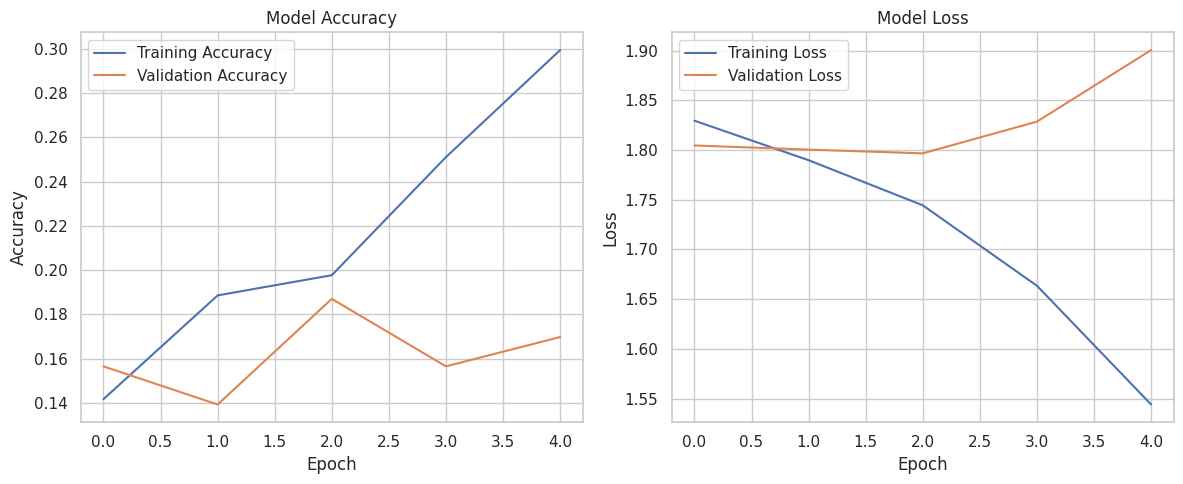

In [16]:


# Retrieve values from the history object
gru_history_dict = gru_history.history

for epoch in range(len(gru_history_dict['loss'])):
    print(f"Epoch {epoch+1:2d} | "
          f"Train Acc: {gru_history_dict['accuracy'][epoch]:.4f} | "
          f"Val Acc: {gru_history_dict['val_accuracy'][epoch]:.4f} | "
          f"Train Loss: {gru_history_dict['loss'][epoch]:.4f} | "
          f"Val Loss: {gru_history_dict['val_loss'][epoch]:.4f}")

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gru_history_dict['accuracy'], label='Training Accuracy')
plt.plot(gru_history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(gru_history_dict['loss'], label='Training Loss')
plt.plot(gru_history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.5},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 256, 'units': 128, 'dropout': 0.5},  # larger embedding, increased units, reg dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smoller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]

fine_tuned_models = []

for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    gru_model = build_gru_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )
    
    gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train new model
    gru_model.fit(
        X_train_pad, y_train_cat,
        epochs=10,
        callbacks=callbacks,
        verbose=1
    )
    
# Predict on test set
y_pred_proba = gru_model.predict(X_test_pad, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred_proba, axis=1)  # predicted class indices

# Convert y_test to class indices if one-hot encoded
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

accuracy = np.mean(y_pred == y_true)
f1 = f1_score(y_true, y_pred, average='weighted')

fine_tuned_models.append({
    'model': gru_model,
    'params': params,
    'accuracy': accuracy,
    'f1_score': f1
})

print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")




Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.5}
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.3062 - loss: 1.7585
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.3239 - loss: 1.6747
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.3406 - loss: 1.6363
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.3705 - loss: 1.5730
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.3950 - loss: 1.5154
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.4154 - loss: 1.4521
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.4432 - loss: 1.3858
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.4654 - loss: 1.3372
Epoch 9/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.4974 - loss: 1.2711
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.5276 - loss: 1.2022

Training model wit


**LSTM and GRU model**

{'embedding_dim': 150, 'units': 150, 'dropout': 0.3}
Model 6 - Accuracy: 0.2255, F1 Score: 0.2312

Event with hyperparameter tuning the result is still not much better than gussing. The model is learning something, but performance is still quite low.



**BERT Architecture Summary**
 
DistilBERT backbone: TFDistilBertModel extracts contextual embeddings from text. The [CLS] token embedding (i.e., outputs.last_hidden_state[:, 0, :]) represents the whole input.

Dense layer: A fully connected layer with 128 units and ReLU adds learnable transformation.

Dropout: 30% dropout is applied during training to prevent overfitting.

Classifier layer: Final softmax layer outputs probabilities for each genre class.

**Mechanics**
Inputs are tokenized and passed as input_ids and attention_mask.

DistilBERT processes the tokens and returns the hidden state.

The first token's embedding ([CLS]) is used as a summary of the input.

This embedding goes through a dense layer, dropout, and finally a softmax classifier.

**Key Feature**
Unlike LSTM or GRU, this model leverages transformer attention, allowing it to capture complex dependencies across the entire text efficiently.

Mixed precision is used to accelerate training and reduce memory usage.

In [38]:


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Sample 10% stratified subsets
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.9, random_state=42, stratify=y_train
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test, y_test, test_size=0.9, random_state=42, stratify=y_test
)

# Convert to list of strings for tokenizer
X_train_small_list = X_train_small.astype(str).tolist()
X_test_small_list = X_test_small.astype(str).tolist()

# Tokenize with truncation and max length (128 tokens max)
train_encodings = tokenizer(
    X_train_small_list, truncation=True, padding=True, max_length=50, return_tensors="tf"
)
test_encodings = tokenizer(
    X_test_small_list, truncation=True, padding=True, max_length=50, return_tensors="tf"
)

# Convert labels to tensors
y_train_small_tf = tf.convert_to_tensor(y_train_small)
y_test_small_tf = tf.convert_to_tensor(y_test_small)


In [39]:

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_small
)).shuffle(1000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_small
)).batch(32)

In [40]:


class BertClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Unfreeze BERT layers for fine-tuning
        self.bert.trainable = True

        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
        
        x = self.dense1(cls_output)
        x = self.dropout(x, training=training)
        return self.classifier(x)

# Setup mixed precision (do this outside the class)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Instantiate the model
model = BertClassifier(num_classes=GENRE_VOCAB_SIZE)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [41]:


bert_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks =callbacks
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2289 - loss: 1.7944 - val_accuracy: 0.2181 - val_loss: 1.7214
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2042 - loss: 1.8123 - val_accuracy: 0.2660 - val_loss: 1.6946
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2305 - loss: 1.7716 - val_accuracy: 0.3085 - val_loss: 1.6779
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2615 - loss: 1.7222 - val_accuracy: 0.3191 - val_loss: 1.6692
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2451 - loss: 1.6996 - val_accuracy: 0.3245 - val_loss: 1.6643
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2945 - loss: 1.7374 - val_accuracy: 0.3351 - val_loss: 1.6606
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2667 - loss: 1.6946 - val_accuracy: 0.3404 - val_loss: 1.6582
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2563 - loss: 1.7221 - val_accuracy: 0.3298 - val_loss:

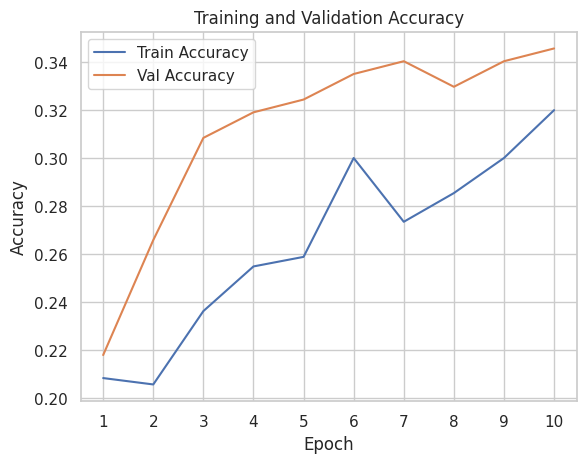

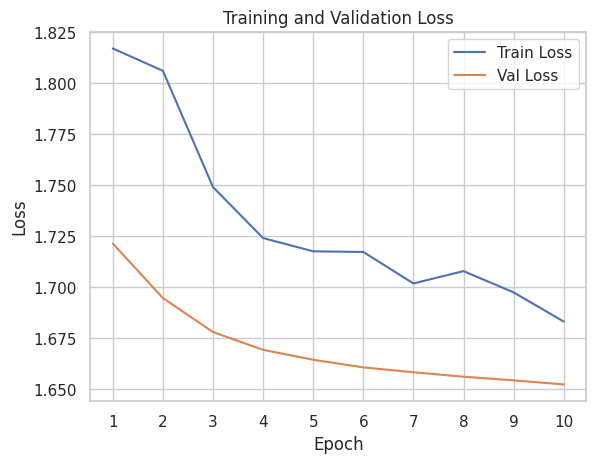

In [42]:


# Accuracy plot
plt.plot(range(1, len(bert_history.history['accuracy']) + 1), bert_history.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(bert_history.history['val_accuracy']) + 1), bert_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(range(1, len(bert_history.history['accuracy']) + 1))  # Set x-axis ticks to whole numbers
plt.legend()
plt.show()
# Loss plot
plt.plot(range(1, len(bert_history.history['loss']) + 1), bert_history.history['loss'], label='Train Loss')
plt.plot(range(1, len(bert_history.history['val_loss']) + 1), bert_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, len(bert_history.history['loss']) + 1))
plt.legend()
plt.show()



**Summary**:

The deep learning model trained to classify poetry by genre based on word usage shows limited success. While training accuracy improves over epochs, validation accuracy remains low and unstable, and validation loss tends to increase, indicating poor generalization. This suggests that simply characterizing poems by their word usage does not yield significant results for genre classification in this dataset. The linguistic features alone are insufficient to capture the nuanced distinctions between genres, and more advanced approaches or additional contextual information may be needed to improve classification performance.


**Application**

This project explores poetry genre classification as a foundation for word-to-word generation. By understanding genre-specific language patterns, a model can be trained to generate text that mimics the tone, structure, and emotion of a given genre. This enables applications in creative writing tools, personalized poetry generation, and genre-aware language modeling.

This code prepares data for word-to-word text generation. It first tokenizes each poem into sequences of word indices. For each sequence, it creates training pairs: an input sequence of previous words (padded to a fixed length) and the next target word. These pairs teach the model to predict the next word based on context. Finally, it trims the dataset to a fixed number of samples to manage training size.


This model generates words by taking a seed sequence of previous words, which is tokenized and padded to a fixed length. The sequence passes through an embedding layer and an LSTM, which learns word patterns and context. The final dense layer outputs a probability distribution over the vocabulary, and the word with the highest probability is selected as the next word. This predicted word can then be added to the input to continue generating text, one word at a time.

In [56]:

BATCH_SIZE = 32
EPOCH = 10
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 10
GENRE_VOCAB_SIZE = 6
EMBEDDING_DIM = 64
MAX_SAMPLES = 50000  # reduce size

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean['Poem'])
sequences = [
    [idx if idx < MAX_VOCAB_SIZE else 1 for idx in seq]
    for seq in tokenizer.texts_to_sequences(df_clean['Poem'])
]


input_sequences = []
target_words = []

for seq in sequences:
    for i in range(1, len(seq)):
        input_seq = pad_sequences([seq[:i]], maxlen=MAX_SEQ_LEN, padding='pre')[0]
        target = seq[i]
        input_sequences.append(input_seq)
        target_words.append(target)

# Now slice to reduce dataset size
input_sequences = input_sequences[:MAX_SAMPLES]
target_words = target_words[:MAX_SAMPLES]

X = np.array(input_sequences)
y = np.array(target_words)

In [57]:


gen_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(MAX_VOCAB_SIZE, activation='softmax')
])

gen_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gen_model.build(input_shape=(None, MAX_SEQ_LEN))
gen_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 10, 64)              │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10000)               │         650,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,327,248 (5.06 MB)

 Trainable params: 1,327,248 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:

# This is a prove of concept. so the training sample is reduc

gen_model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.1353 - loss: 6.8276
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1367 - loss: 6.1613
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1409 - loss: 6.0328
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.1474 - loss: 5.9153
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1541 - loss: 5.8413
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1598 - loss: 5.7324
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1627 - loss: 5.6272
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1668 - loss: 5.5326
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1731 - loss: 5.4307
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.1745 - loss: 5.3529


In [78]:


def generate_text(seed_text, next_words=20, max_seq_len=MAX_SEQ_LEN, tokenizer=tokenizer, model=gen_model, temperature=0):
    result = seed_text.split()
    index_word = tokenizer.index_word

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([' '.join(result)])
        token_list = token_list[0]
        token_list = np.array(token_list[-max_seq_len:])
        token_list = np.pad(token_list, (max_seq_len - len(token_list), 0), mode='constant')
        token_list = token_list.reshape(1, max_seq_len)  # shape: (1, MAX_SEQ_LEN)

        # ✅ Predict using Sequential model
        predicted_probs = model.predict(token_list, verbose=0)[0]  # shape: (vocab_size,)

        predicted_id = sample_with_temperature(predicted_probs, temperature)
        output_word = index_word.get(predicted_id + 1, '<OOV>')  # adjust +1 if needed
        result.append(output_word)

    return ' '.join(result)

def sample_with_temperature(preds, temperature=0):
    preds = np.asarray(preds).astype('float64')
    
    if temperature == 0:
        # No randomness: always choose the most probable word
        return np.argmax(preds)

    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [79]:


seed_input = widgets.Text(
    value='',
    placeholder='Type seed text here',
    description='Seed:',
    layout=widgets.Layout(width='60%')
)

# Slider to select number of words to generate
word_slider = widgets.IntSlider(
    value=10,
    min=5,
    max=50,
    step=1,
    description='Words:',
    continuous_update=False
)

# Slider to select temperature (from 0 to 2 for creativity control)
temperature_slider = widgets.FloatSlider(
    value=0.7,
    min=0.0,
    max=2.0,
    step=0.05,
    description='Temperature:',
    continuous_update=False,
    readout_format='.2f'
)

# Button to generate text
generate_button = widgets.Button(description="Generate")

# Output area
output_area = widgets.Output()

# Action on button click
def on_generate_clicked(b):
    output_area.clear_output()
    seed = seed_input.value
    n_words = word_slider.value
    temperature = temperature_slider.value
    with output_area:
        generated = generate_text(seed, next_words=n_words, temperature=temperature)
        print(generated)

generate_button.on_click(on_generate_clicked)

# Display UI components
display(seed_input, word_slider, temperature_slider, generate_button, output_area)

Text(value='', description='Seed:', layout=Layout(width='60%'), placeholder='Type seed text here')

IntSlider(value=10, continuous_update=False, description='Words:', max=50, min=5)

FloatSlider(value=0.7, continuous_update=False, description='Temperature:', max=2.0, step=0.05)

Button(description='Generate', style=ButtonStyle())

Output()


**Word-to-Word Text Generation Model**

The word-to-word text generation model predicts the next word in a sequence based on a given seed text and the learned language patterns from the training data. By iteratively predicting and appending one word at a time, the model generates coherent sequences that reflect the style and vocabulary it has learned.

A key parameter controlling the creativity and variability of the generated text is the temperature. Temperature adjusts the randomness of the word selection from the predicted probability distribution:

Low temperature (close to 0): The model favors the most probable next word, resulting in more predictable and repetitive output. This can lead to repeated words or phrases and less diverse text.

High temperature (>1): The model allows for more randomness, sampling from a wider range of possible words. This increases creativity but can reduce coherence and increase the chance of nonsensical output.


**Overall Conclusion**

Poetry classification and generation present unique challenges compared to more structured text domains. Poetry often lacks clear, consistent labels and contains fewer explicit signal words that typical classification models rely on, making accurate categorization difficult. This ambiguity reflects poetry’s inherent dependence on human creativity, metaphor, and subtlety, which are not easily captured by conventional machine learning approaches.

Similarly, word-to-word text generation models trained on poetry datasets face limitations due to the relatively small size and stylistic complexity of available corpora. While current models can produce coherent sequences, they struggle to fully replicate the nuanced creativity and depth found in human-written poetry. Adjusting parameters like temperature helps balance between predictable and creative outputs but does not entirely overcome these constraints.

Future progress in this area will likely require more advanced architectures capable of better understanding poetic context and semantics, as well as larger, richer datasets that more comprehensively represent diverse poetic styles and themes. Such improvements are essential to bridge the gap between algorithmic generation and genuine human artistry in poetry.